<a href="https://colab.research.google.com/github/kursatkara/MAE_5020_S24/blob/master/05_08_01_PyDMD_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PyDMD**
"PyDMD: A Python package for robust dynamic mode decomposition", https://doi.org/10.48550/arXiv.2402.07463

 "PyDMD is a Python package designed for Dynamic Mode Decomposition (DMD), a data-driven method used for analyzing and extracting spatiotemporal coherent structures from time-varying datasets. It provides a comprehensive and user-friendly interface for performing DMD analysis, making it a valuable tool for researchers, engineers, and data scientists working in various fields."

#**Tutorial 1: Dynamic Mode Decomposition on a toy dataset**

This notebook is based on the [tutorial 1](https://github.com/kursatkara/PyDMD/blob/master/tutorials/tutorial1/tutorial-1-dmd.ipynb) of PyDMD modified to run on Google Colab.

The main purpose of this tutorial is to show the capabilities of the algorithm and the package interface.

First install the PyDMD package:

In [ ]:
try:
    # Try importing the pydmd module
    import pydmd
    print("PyDMD is already installed.")
except ImportError:
    # If the import fails, install the pydmd package
    print("PyDMD is not installed. Installing now...")
    !pip install pydmd
    # Import pydmd after installation
    import pydmd
    print("PyDMD has been successfully installed.")


PyDMD is already installed.


Import DMD classes from the PyDMD package, set matplotlib for the notebook, and import numpy. Also, import some plotting tools and some data preprocessing tools.

In [ ]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

from pydmd import DMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing

Create the input data by summing two different functions:<br>
$f_1(x,t) = \text{sech}(x+3)\cos(2.3t)$<br>
$f_2(x,t) = 2\text{sech}(x)\tanh(x)\sin(2.8t)$.<br>

In [ ]:
#Define the functions
def f1(xx, tt):
    return 2 * np.cos(xx) * np.exp(1j * tt)

def f2(xx, tt):
    return np.sin(xx) * np.exp(3j * tt)

In [ ]:
# We create the input data by summing two different functions:
#def f1(x, t):
#    return 1.0 / np.cosh(x + 3) * np.cos(2.3 * t)
#
#def f2(x, t):
#    return 2.0 / np.cosh(x) * np.tanh(x) * np.sin(2.8 * t)


nx = 65  # number of grid points along space dimension
nt = 129  # number of grid points along time dimension
#nx = 401
#nt = 201

# Define the space and time grid for data collection.
x = np.linspace(-5, 5, nx)
t = np.linspace(0, 4 * np.pi, nt)
xgrid, tgrid = np.meshgrid(x, t)
dt = t[1] - t[0]  # time step between each snapshot

# Data consists of 2 spatiotemporal signals.
X1 = f1(xgrid, tgrid)
X2 = f2(xgrid, tgrid)
X = X1 + X2

# Make a version of the data with noise.
mean = 0
std_dev = 0.2
random_matrix = np.random.normal(mean, std_dev, size=(nt, nx))
Xn = X + random_matrix

X.shape

(129, 65)

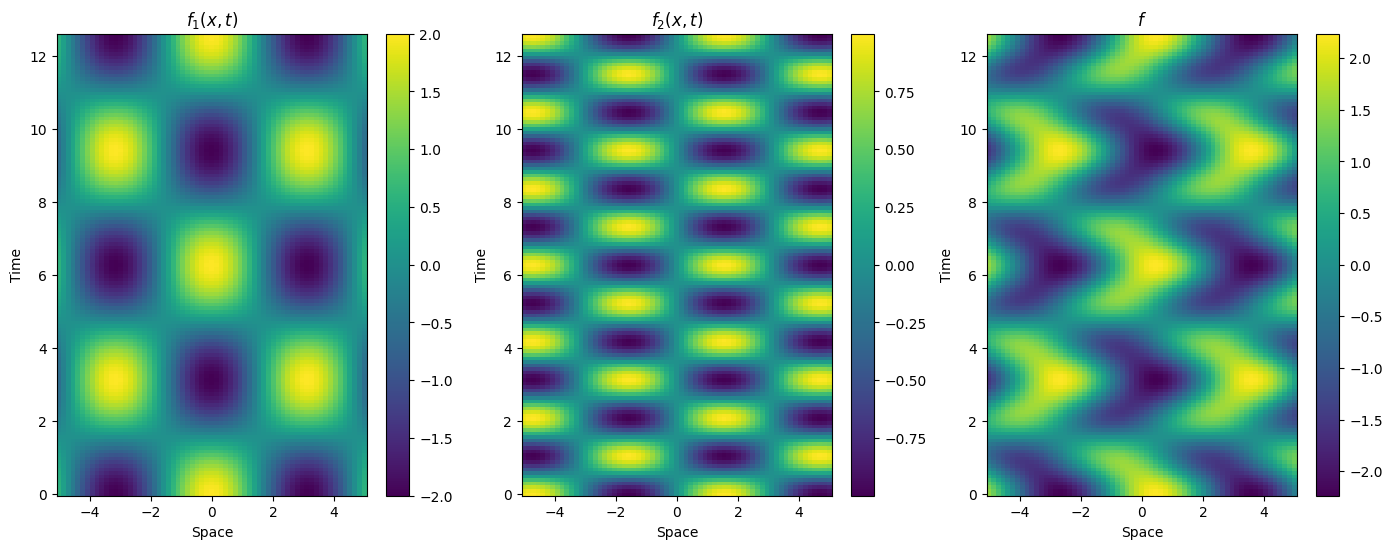

In [ ]:
# The plots below represent these functions and the dataset without noise.
titles = ["$f_1(x,t)$", "$f_2(x,t)$", "$f$"]
data = [X1, X2, X]

fig = plt.figure(figsize=(17, 6), dpi=100)
for n, title, d in zip(range(131, 134), titles, data):
    plt.subplot(n)
    plt.pcolor(xgrid, tgrid, d.real)
    plt.title(title)
    plt.xlabel("Space")
    plt.ylabel("Time")
    plt.colorbar()
plt.show()

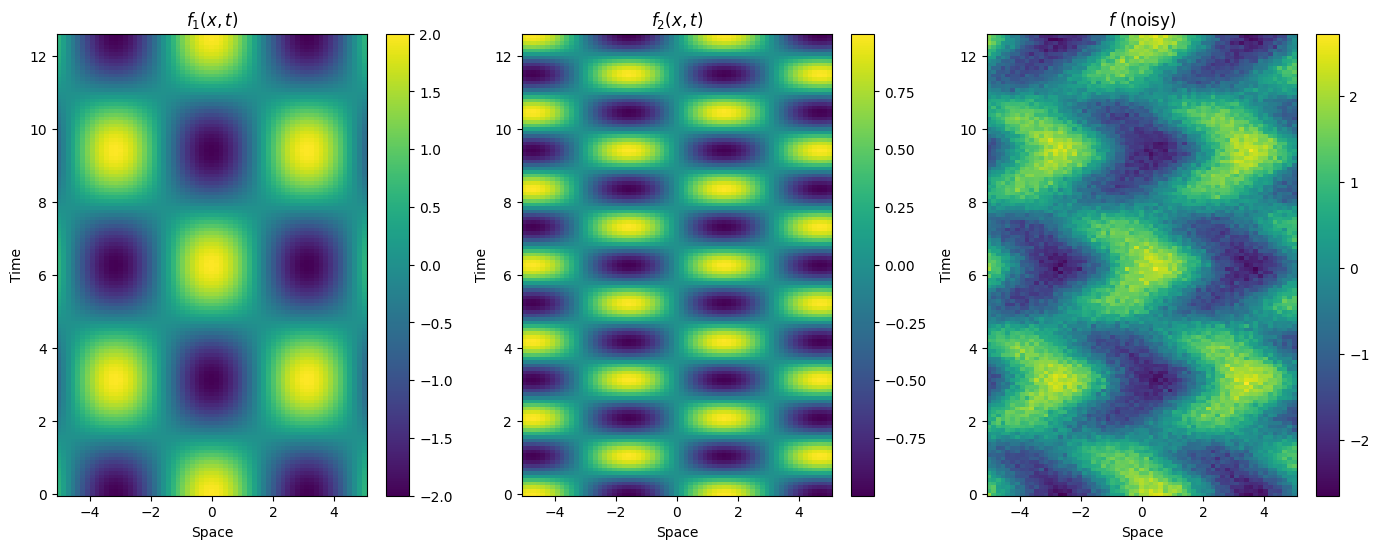

In [ ]:
# The plots below represent these functions and the dataset with noise.
titles = ["$f_1(x,t)$", "$f_2(x,t)$", "$f$ (noisy)"]
data = [X1, X2, Xn]

fig = plt.figure(figsize=(17, 6), dpi=100)
for n, title, d in zip(range(131, 134), titles, data):
    plt.subplot(n)
    plt.pcolor(xgrid, tgrid, d.real)
    plt.title(title)
    plt.xlabel("Space")
    plt.ylabel("Time")
    plt.colorbar()
plt.show()

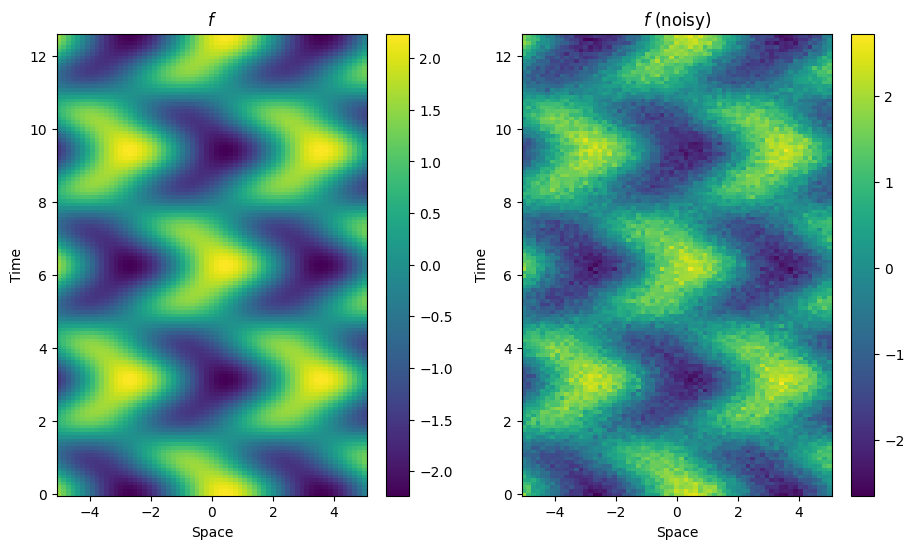

In [ ]:
titles = ["$f$", "$f$ (noisy)"]
data = [X, Xn]

fig = plt.figure(figsize=(11,6), dpi=100)
for n, title, d in zip(range(121, 123), titles, data):
    plt.subplot(n)
    plt.pcolor(xgrid, tgrid, d.real)
    plt.title(title)
    plt.xlabel("Space")
    plt.ylabel("Time")
    plt.colorbar()
plt.show()

## DMD with perfect data (i.e. clean simulation data)

**We begin by presenting the following results so that we know what we should be expecting when we apply DMD to this data set. We will go more in depth about the individual steps on how to use PyDMD later.**

Notice that by construction, our data set is completely real (i.e. it doesn't possess imaginary components) and it contains 2 distinct spatiotemporal features that oscillate in time. Hence a successful DMD model should not only be able to faithfully reconstruct the input data, but it should also be able to disambiguate the 2 spatial modes, as well as recover their respective frequencies of oscillation $\omega_1=2.3$ and $\omega_2=2.8$.

Remember that the input data by summing two different functions:<br>
$f_1(x,t) = \text{sech}(x+3)\cos(2.3t)$<br>
$f_2(x,t) = 2\text{sech}(x)\tanh(x)\sin(2.8t)$.<br>

To capture such oscillations from real data sets, we will need 2 DMD eigenvalues for each oscillation: one to capture the frequency of the oscillation and one to capture its complex conjugate. Hence for our particular data set, we need at least 4 DMD eigenvalues / modes in order to capture the full extent of our data. We will also need time-delay data preprocessing in order to recover this rank-4 structure, but more on that later.

Since our data is evenly-spaced in time and sufficiently high-dimensional after we appropriately preprocess our data, exact DMD (implemented by `DMD`) is able to successfully extract the 2 spatiotemporal modes that make up our system as long as we use clean data.

**The results presented below are essentially perfect results.**

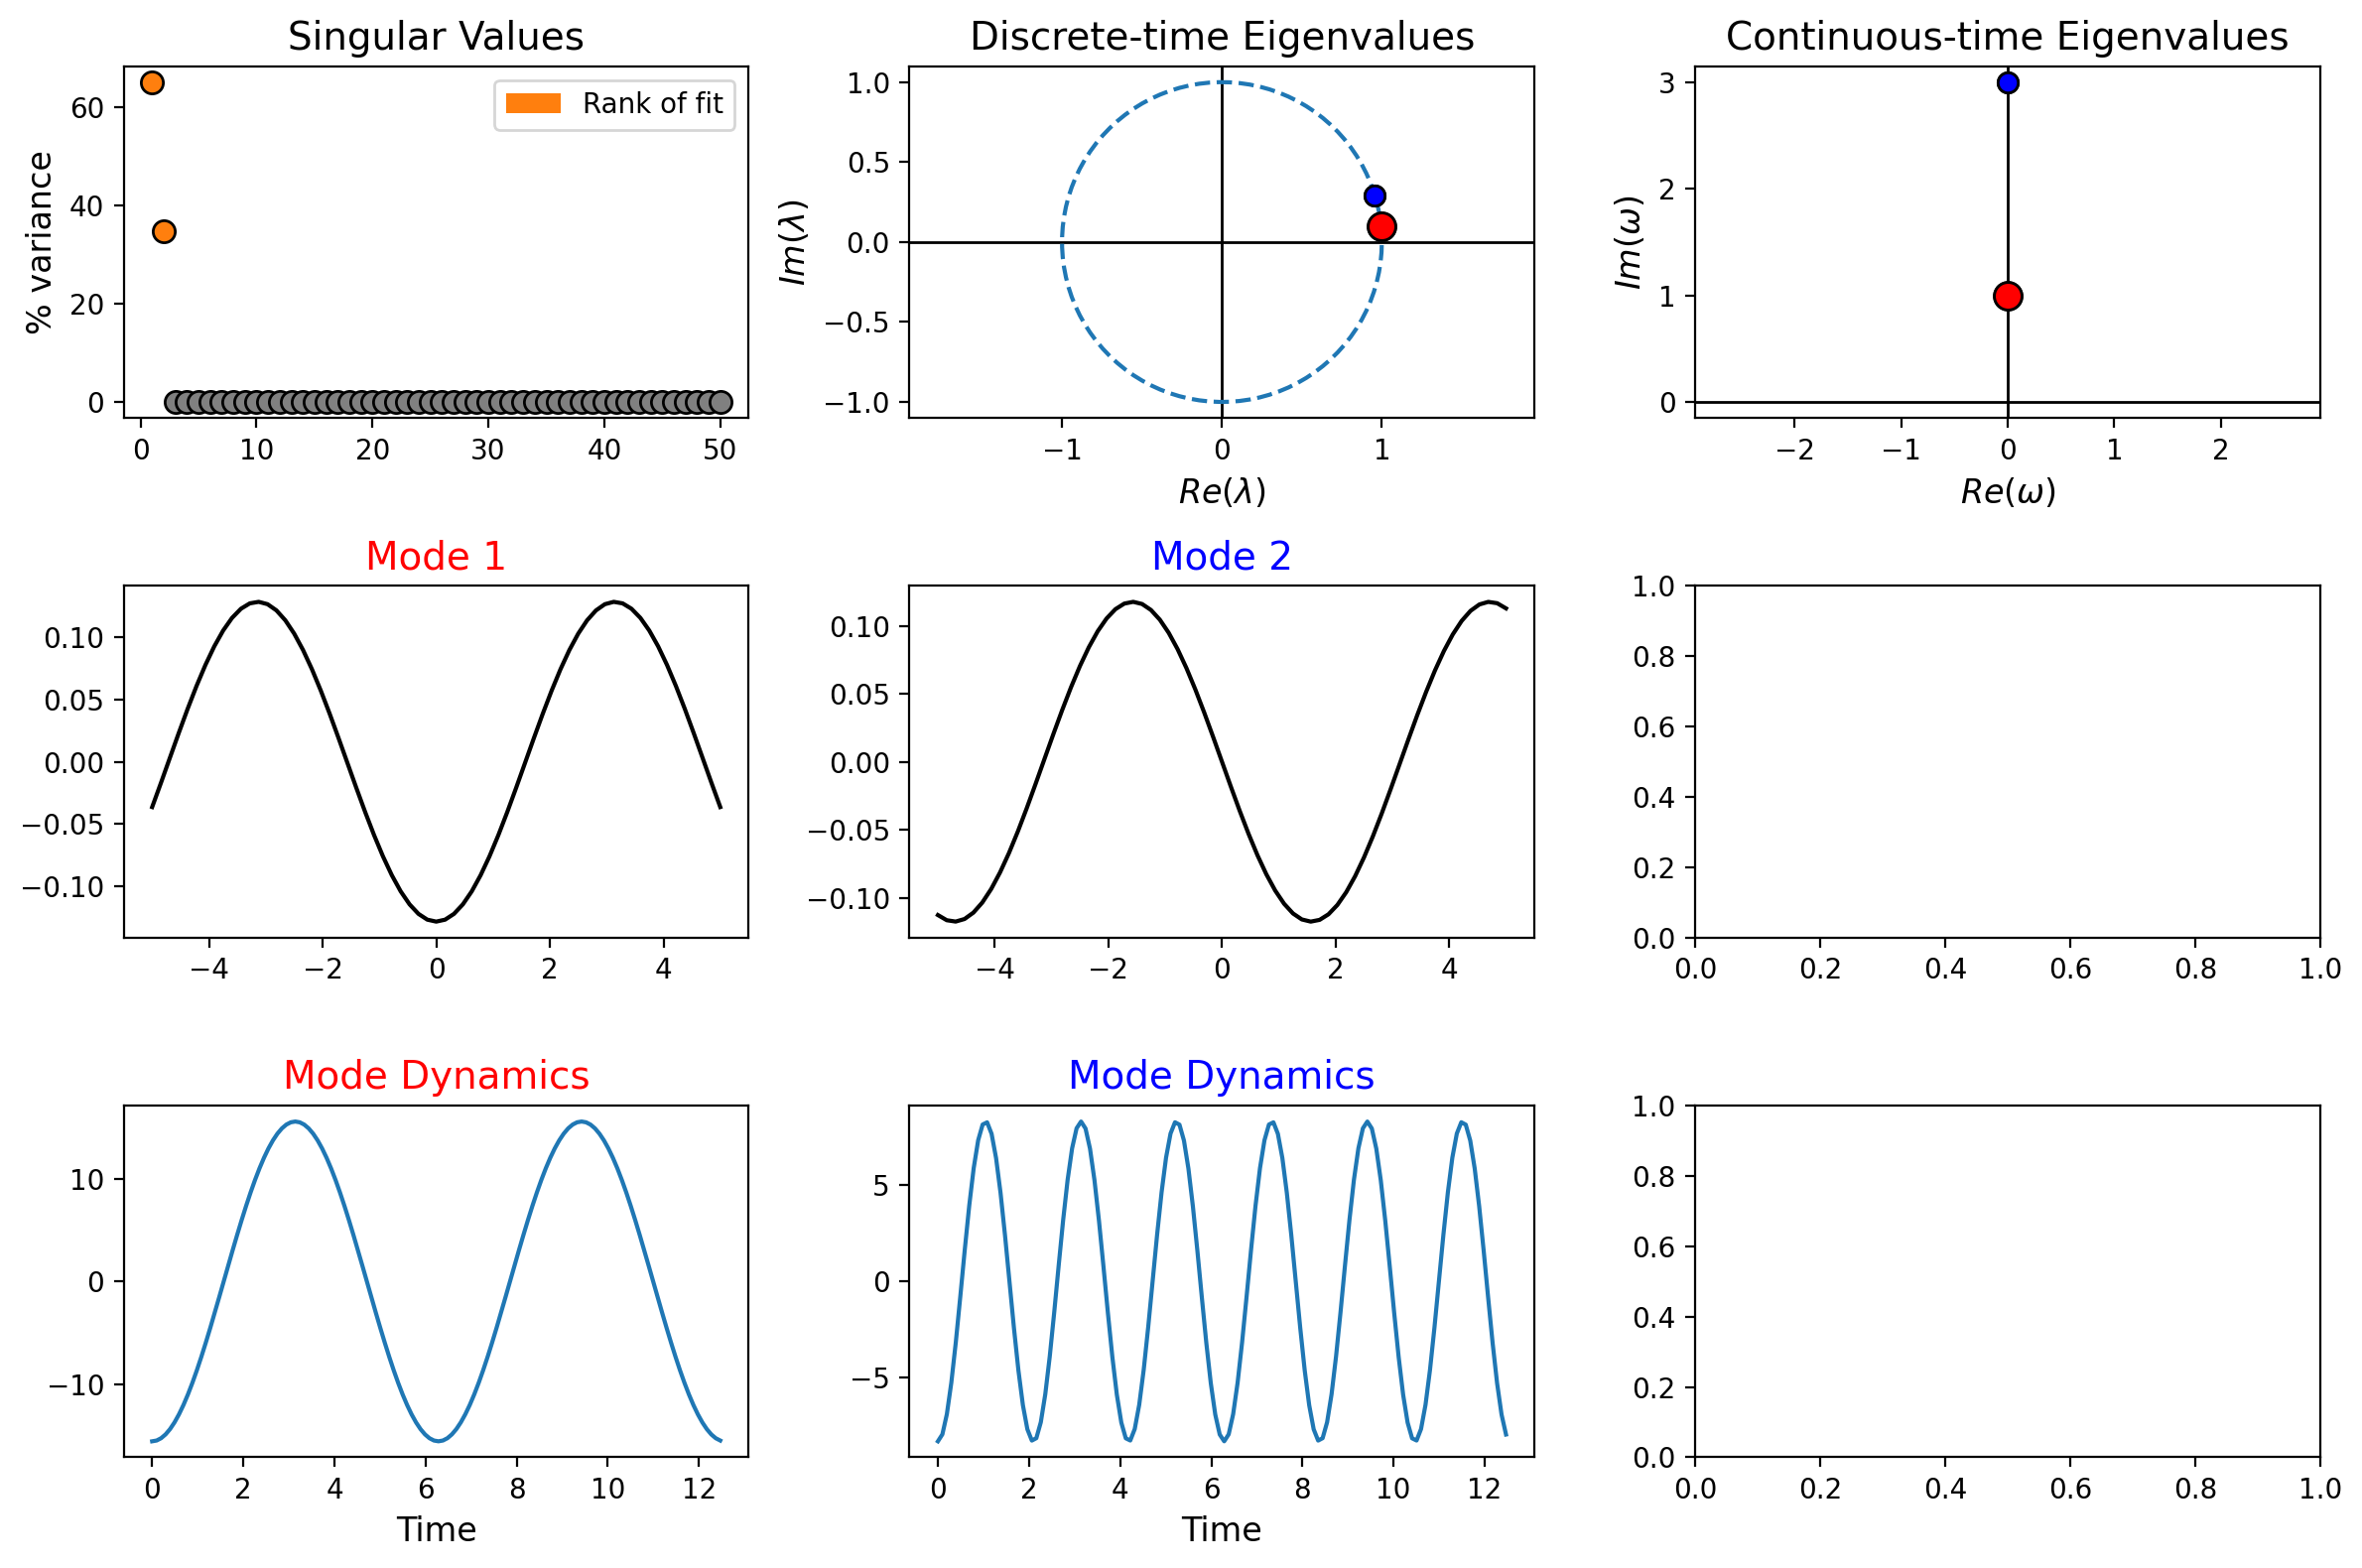

Frequencies (imaginary component): [ 0.+1.j -0.+3.j]


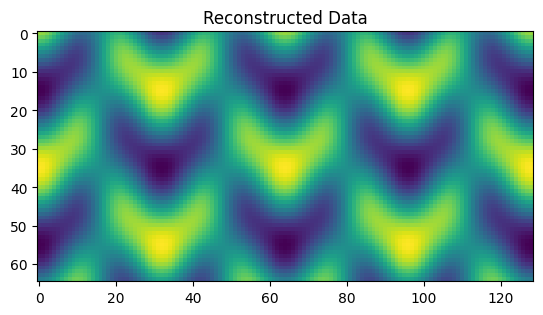

In [ ]:
d = 2  # we will use this number of delays throughout the tutorial
dmd = DMD(svd_rank=2)
delay_dmd = hankel_preprocessing(dmd, d=d)
delay_dmd.fit(X.T)
plot_summary(delay_dmd, x=x, t=dt, d=d)
print(
    f"Frequencies (imaginary component): {np.round(np.log(delay_dmd.eigs) / dt, decimals=12)}"
)
plt.title("Reconstructed Data")
plt.imshow(delay_dmd.reconstructed_data.real)
plt.show()
#plt.title("Clean Ground Truth Data")
#plt.imshow(X.T)
#plt.show()

## DMD steps for handling real data (i.e. data with noise)

**Step 1:** Do a time-delay embedding (`d` is number of delay embeddings).

**Step 2:** Apply BOP-DMD (`num_trials` is number of statistical bags).

**Step 3:** OPTIONAL -- Constrain the eigenvalues (i) left-half plane, (ii) imaginary axis, (iii) complex conjugate pairs.

## Steps 1 and 2: Using PyDMD on real data

We currently have the temporal snapshots in the input matrix rows. We can easily create a new DMD instance and exploit it in order to compute DMD on the data. Since the snapshots must be arranged by columns, we need to transpose the data matrix in this case.

Starting with **Step 1**, we apply a time-delay embedding to our data before applying our DMD method of choice. In order to do that, we wrap our DMD instance in the `hankel_preprocessing` routine and provide our desired number of delays `d`. We will dive more into *why* we need the time-delay embeddings later in the tutorial.

Continuing on to **Step 2**, we note that in order to apply the BOP-DMD method in particular, all we need to do is build `BOPDMD` model as our particular DMD instance. Once the instance is wrapped, we can go ahead with the fit.

A summary of the DMD results can then be plotted using the `plot_summary` function.

Notice that from this process alone, we are able to obtain fairly accurate spatial modes, a good approximation of the temporal frequencies, and a good reconstruction of our data, even in the presence of high amounts of noise.

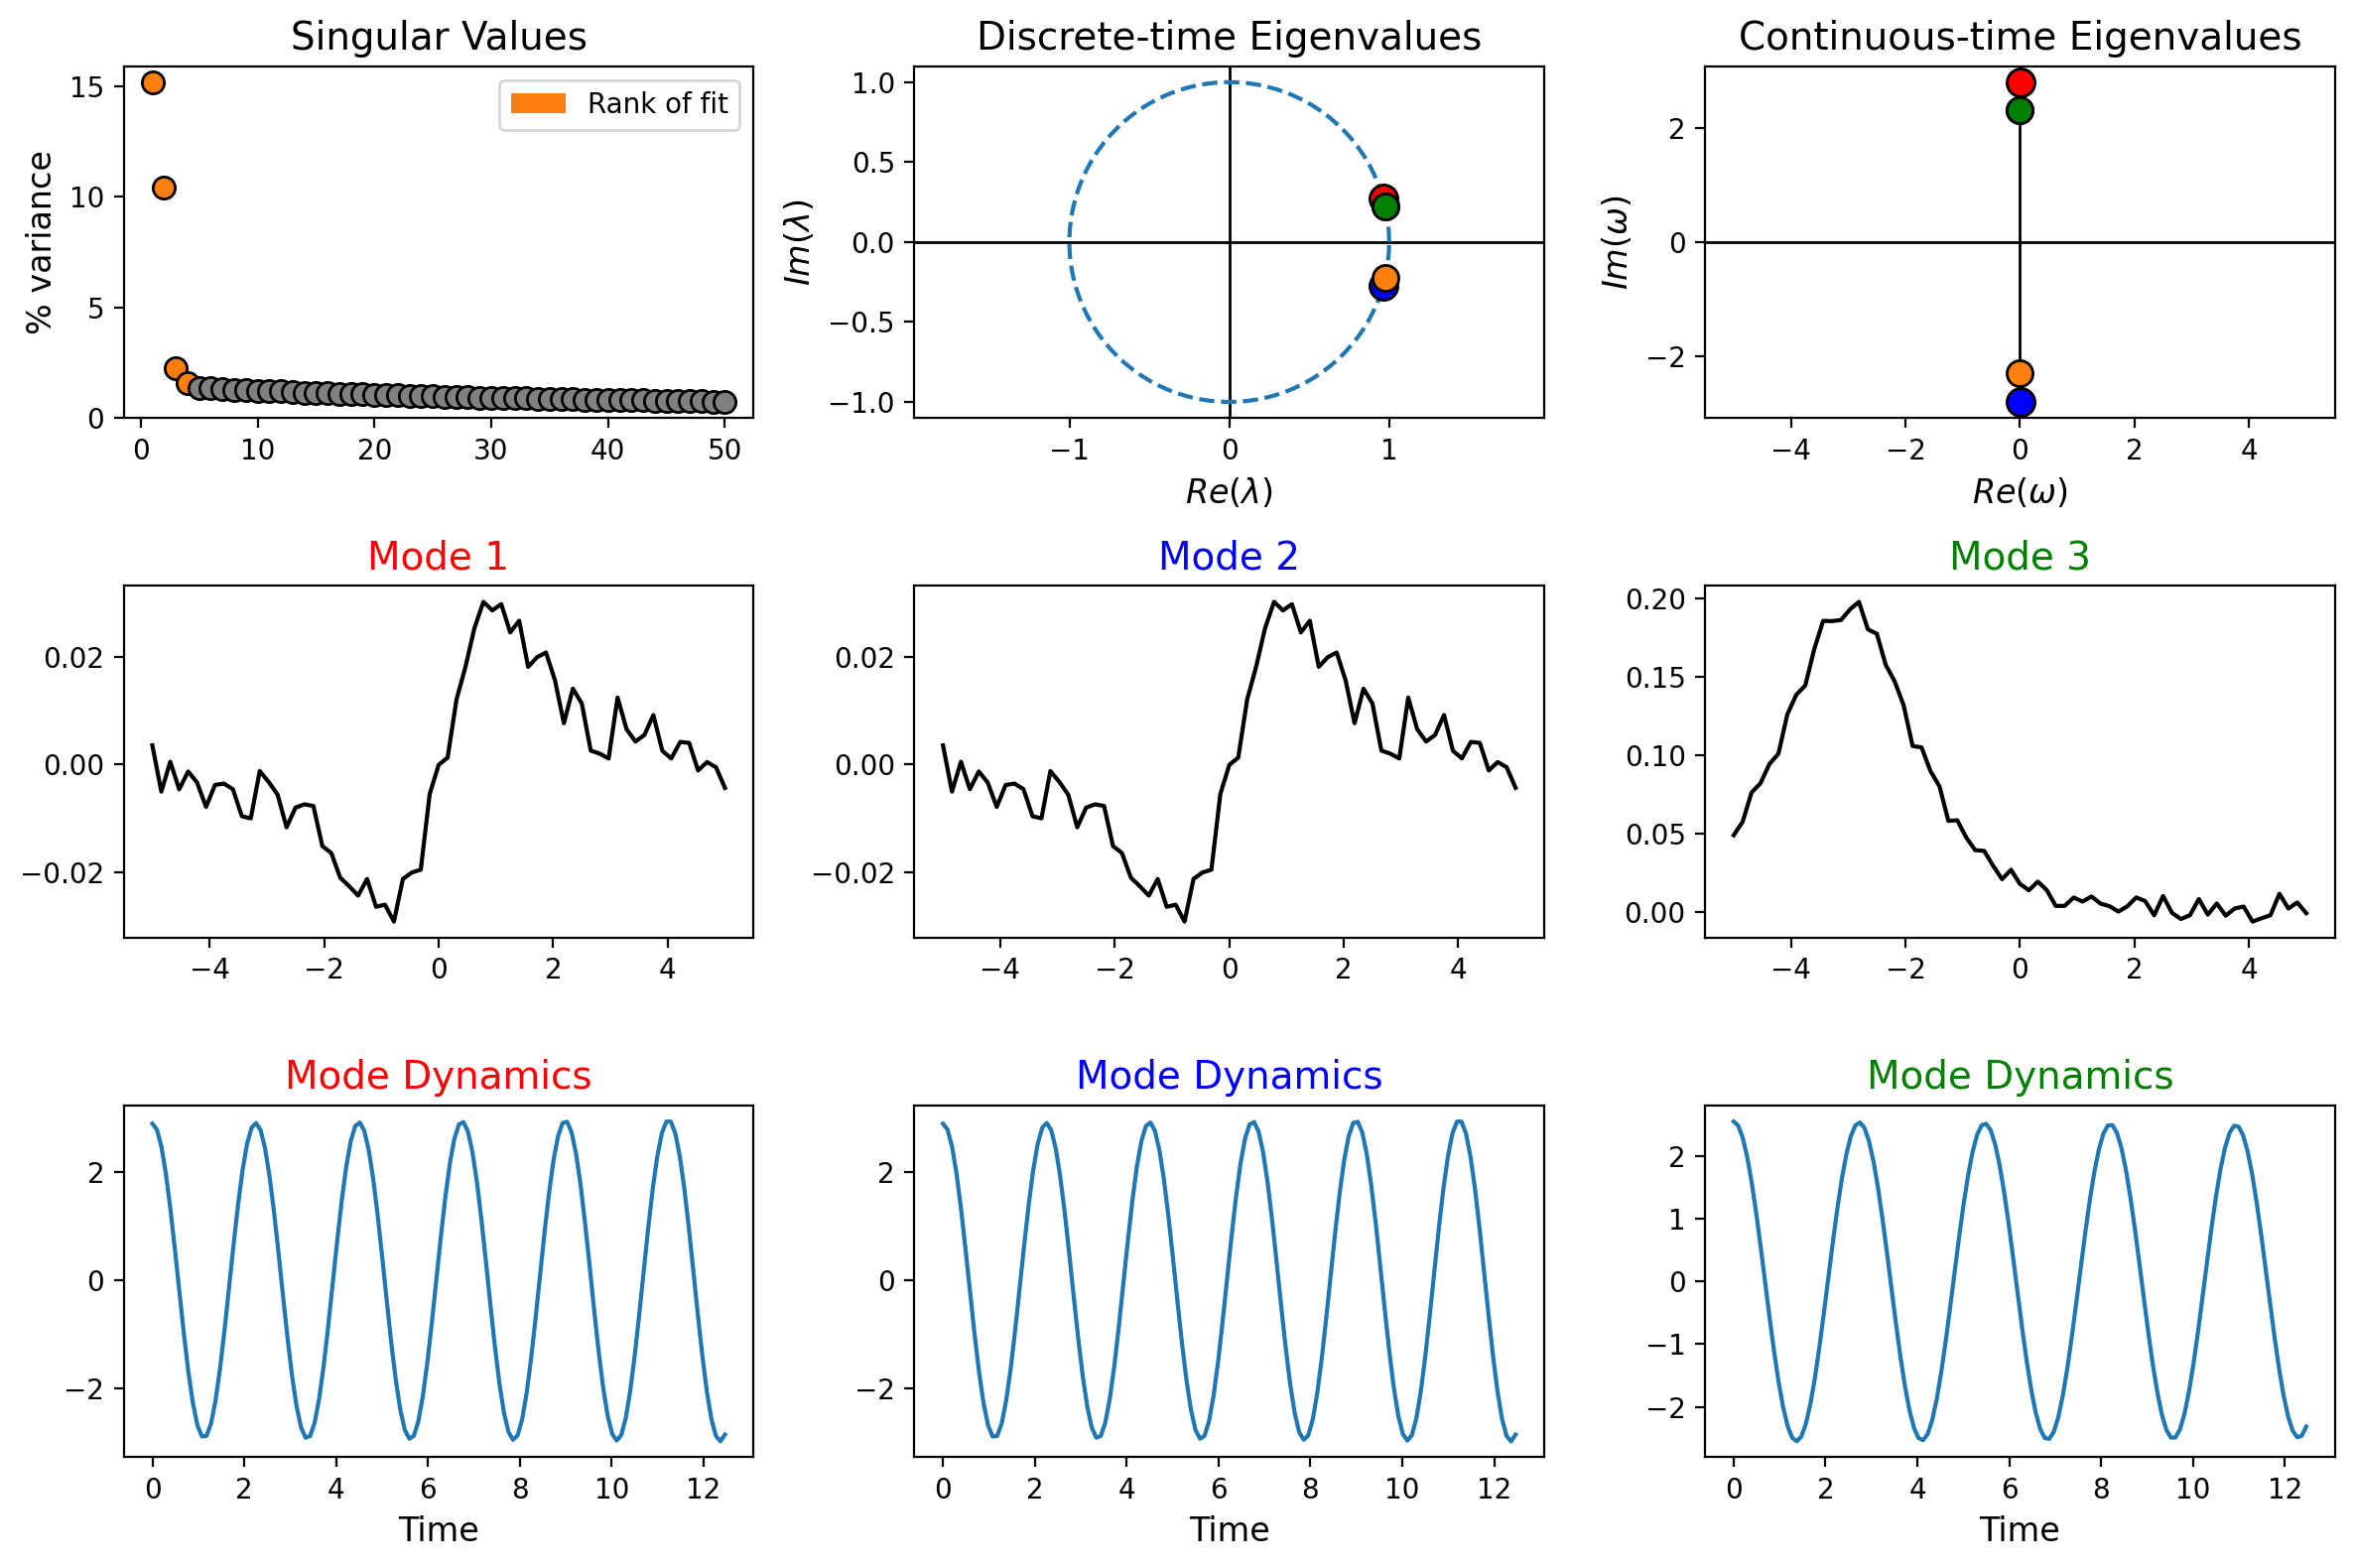

Frequencies (imaginary component): [ 0.002+2.795j  0.002-2.795j -0.002+2.298j -0.002-2.298j]


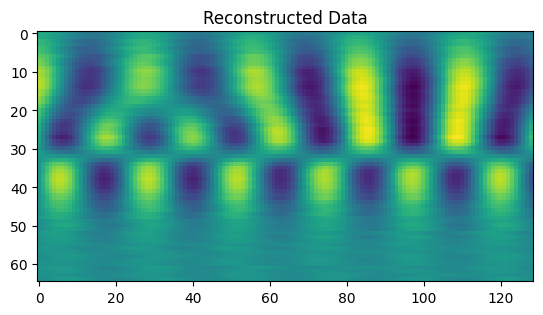

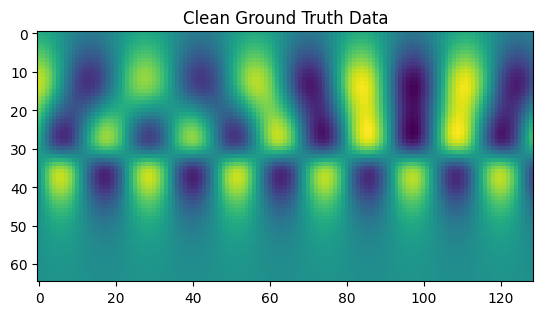

In [ ]:
# Build the Optimized DMD model.
# num_trials=0 gives Optimized DMD, without bagging.
optdmd = BOPDMD(svd_rank=4, num_trials=0)

# Wrap the model with the preprocessing routine.
delay_optdmd = hankel_preprocessing(optdmd, d=d)

# Fit the model to the noisy data.
# Note: BOPDMD models need the data X and the times of data collection t for fitting.
# Hence if we apply time-delay, we must adjust the length of our time vector accordingly.
delay_t = t[: -d + 1]
delay_optdmd.fit(Xn.T, t=delay_t)

# Plot a summary of the DMD results.
plot_summary(delay_optdmd, x=x, d=d)

# Print computed eigenvalues (frequencies are given by imaginary components).
# Also plot the resulting data reconstruction.
print(
    f"Frequencies (imaginary component): {np.round(delay_optdmd.eigs, decimals=3)}"
)
plt.title("Reconstructed Data")
plt.imshow(delay_optdmd.reconstructed_data.real)
plt.show()
plt.title("Clean Ground Truth Data")
plt.imshow(X.T)
plt.show()

The DMD object contains the principal information about the decomposition:
- the attribute `modes` is a 2D numpy array where the columns are the low-rank structures individuated;
- the attribute `dynamics` is a 2D numpy array where the rows refer to the time evolution of each mode;
- the attribute `eigs` refers to the eigenvalues of the low dimensional operator;
- the attribute `amplitudes` gives the spatiotemporal mode coefficients used for reconstruction;
- the attribute `reconstructed_data` refers to the approximated system evolution.

Although these attributes may be accessed directly from a fitted DMD object as demonstrated below, we note that the `plot_summary` function plots a summarizing view of many of these attributes automatically.

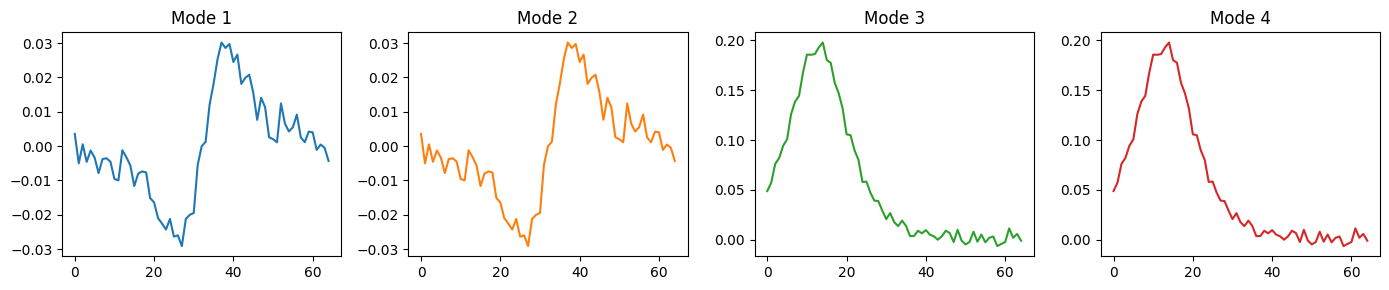

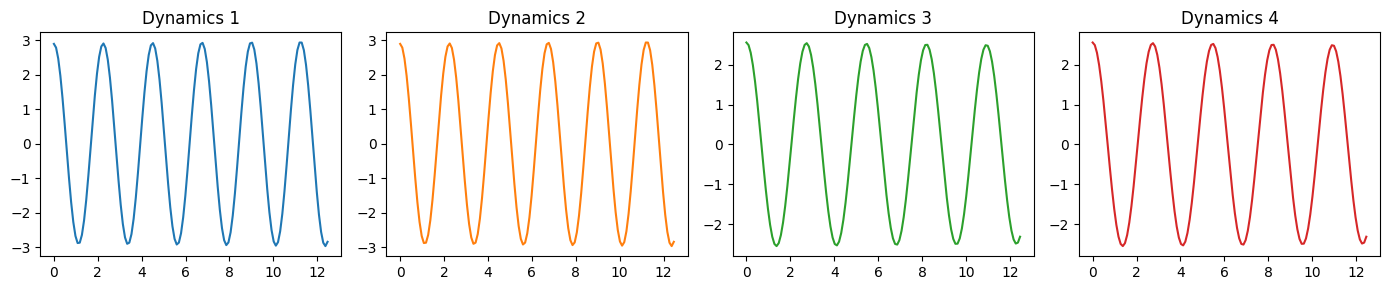

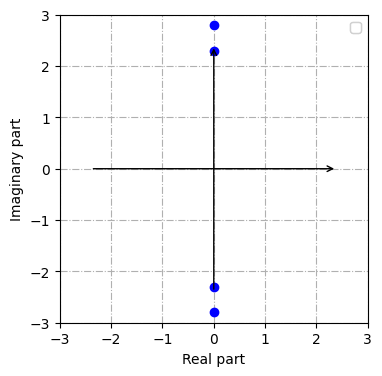

Computed amplitudes: [2.898 2.898 2.56  2.56 ]



In [ ]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

# Plotting the modes individually...
plt.figure(figsize=(14, 3))
for i, mode in enumerate(delay_optdmd.modes.T):
    # Get the average across delays, since we used time-delay.
    mode = np.average(mode.reshape(d, len(mode) // d), axis=0)
    plt.subplot(1, len(delay_optdmd.modes.T), i + 1)
    plt.plot(mode.real, c=colors[i])
    plt.title(f"Mode {i + 1}")
plt.tight_layout()
plt.show()

# Plotting the dynamics individually...
plt.figure(figsize=(14, 3))
for i, dynamic in enumerate(delay_optdmd.dynamics):
    plt.subplot(1, len(delay_optdmd.dynamics), i + 1)
    plt.plot(delay_t, dynamic.real, c=colors[i])
    plt.title(f"Dynamics {i + 1}")
plt.tight_layout()
plt.show()

# Plot the eigenvalues.
plot_eigs(delay_optdmd, show_axes=True, show_unit_circle=False, figsize=(4, 4))

# Print the amplitudes.
print(f"Computed amplitudes: {np.round(delay_optdmd.amplitudes, decimals=3)}\n")

Remember that the input data by summing two different functions:<br>
$f_1(x,t) = \text{sech}(x+3)\cos(2.3t)$<br>
$f_2(x,t) = 2\text{sech}(x)\tanh(x)\sin(2.8t)$.<br>

## Step 3: DMD with constraints

`BOPDMD` models also have the option to specify the structure of the eigenvalues that they compute. More specifically, users can impose the following constraints, as well as any valid combination of them.

- **Stable:** constrain eigenvalues to have non-positive real parts.
- **Imaginary:** constrain eigenvalues to be purely imaginary.
- **Conjugate pairs:** constrain eigenvalues to always appear with their complex conjugate.

This can be especially helpful for dealing with noise and preventing growth/decay of your dynamics.

Notice that by taking this extra step, the eigenvalues computed by BOP-DMD are now perfectly imaginary, and they now come in perfect complex conjugate pairs. Also notice that this is automatically detected by `plot_summary`, which now plots the complex conjugate eigenvalue pairs and their respective mode in the same color.

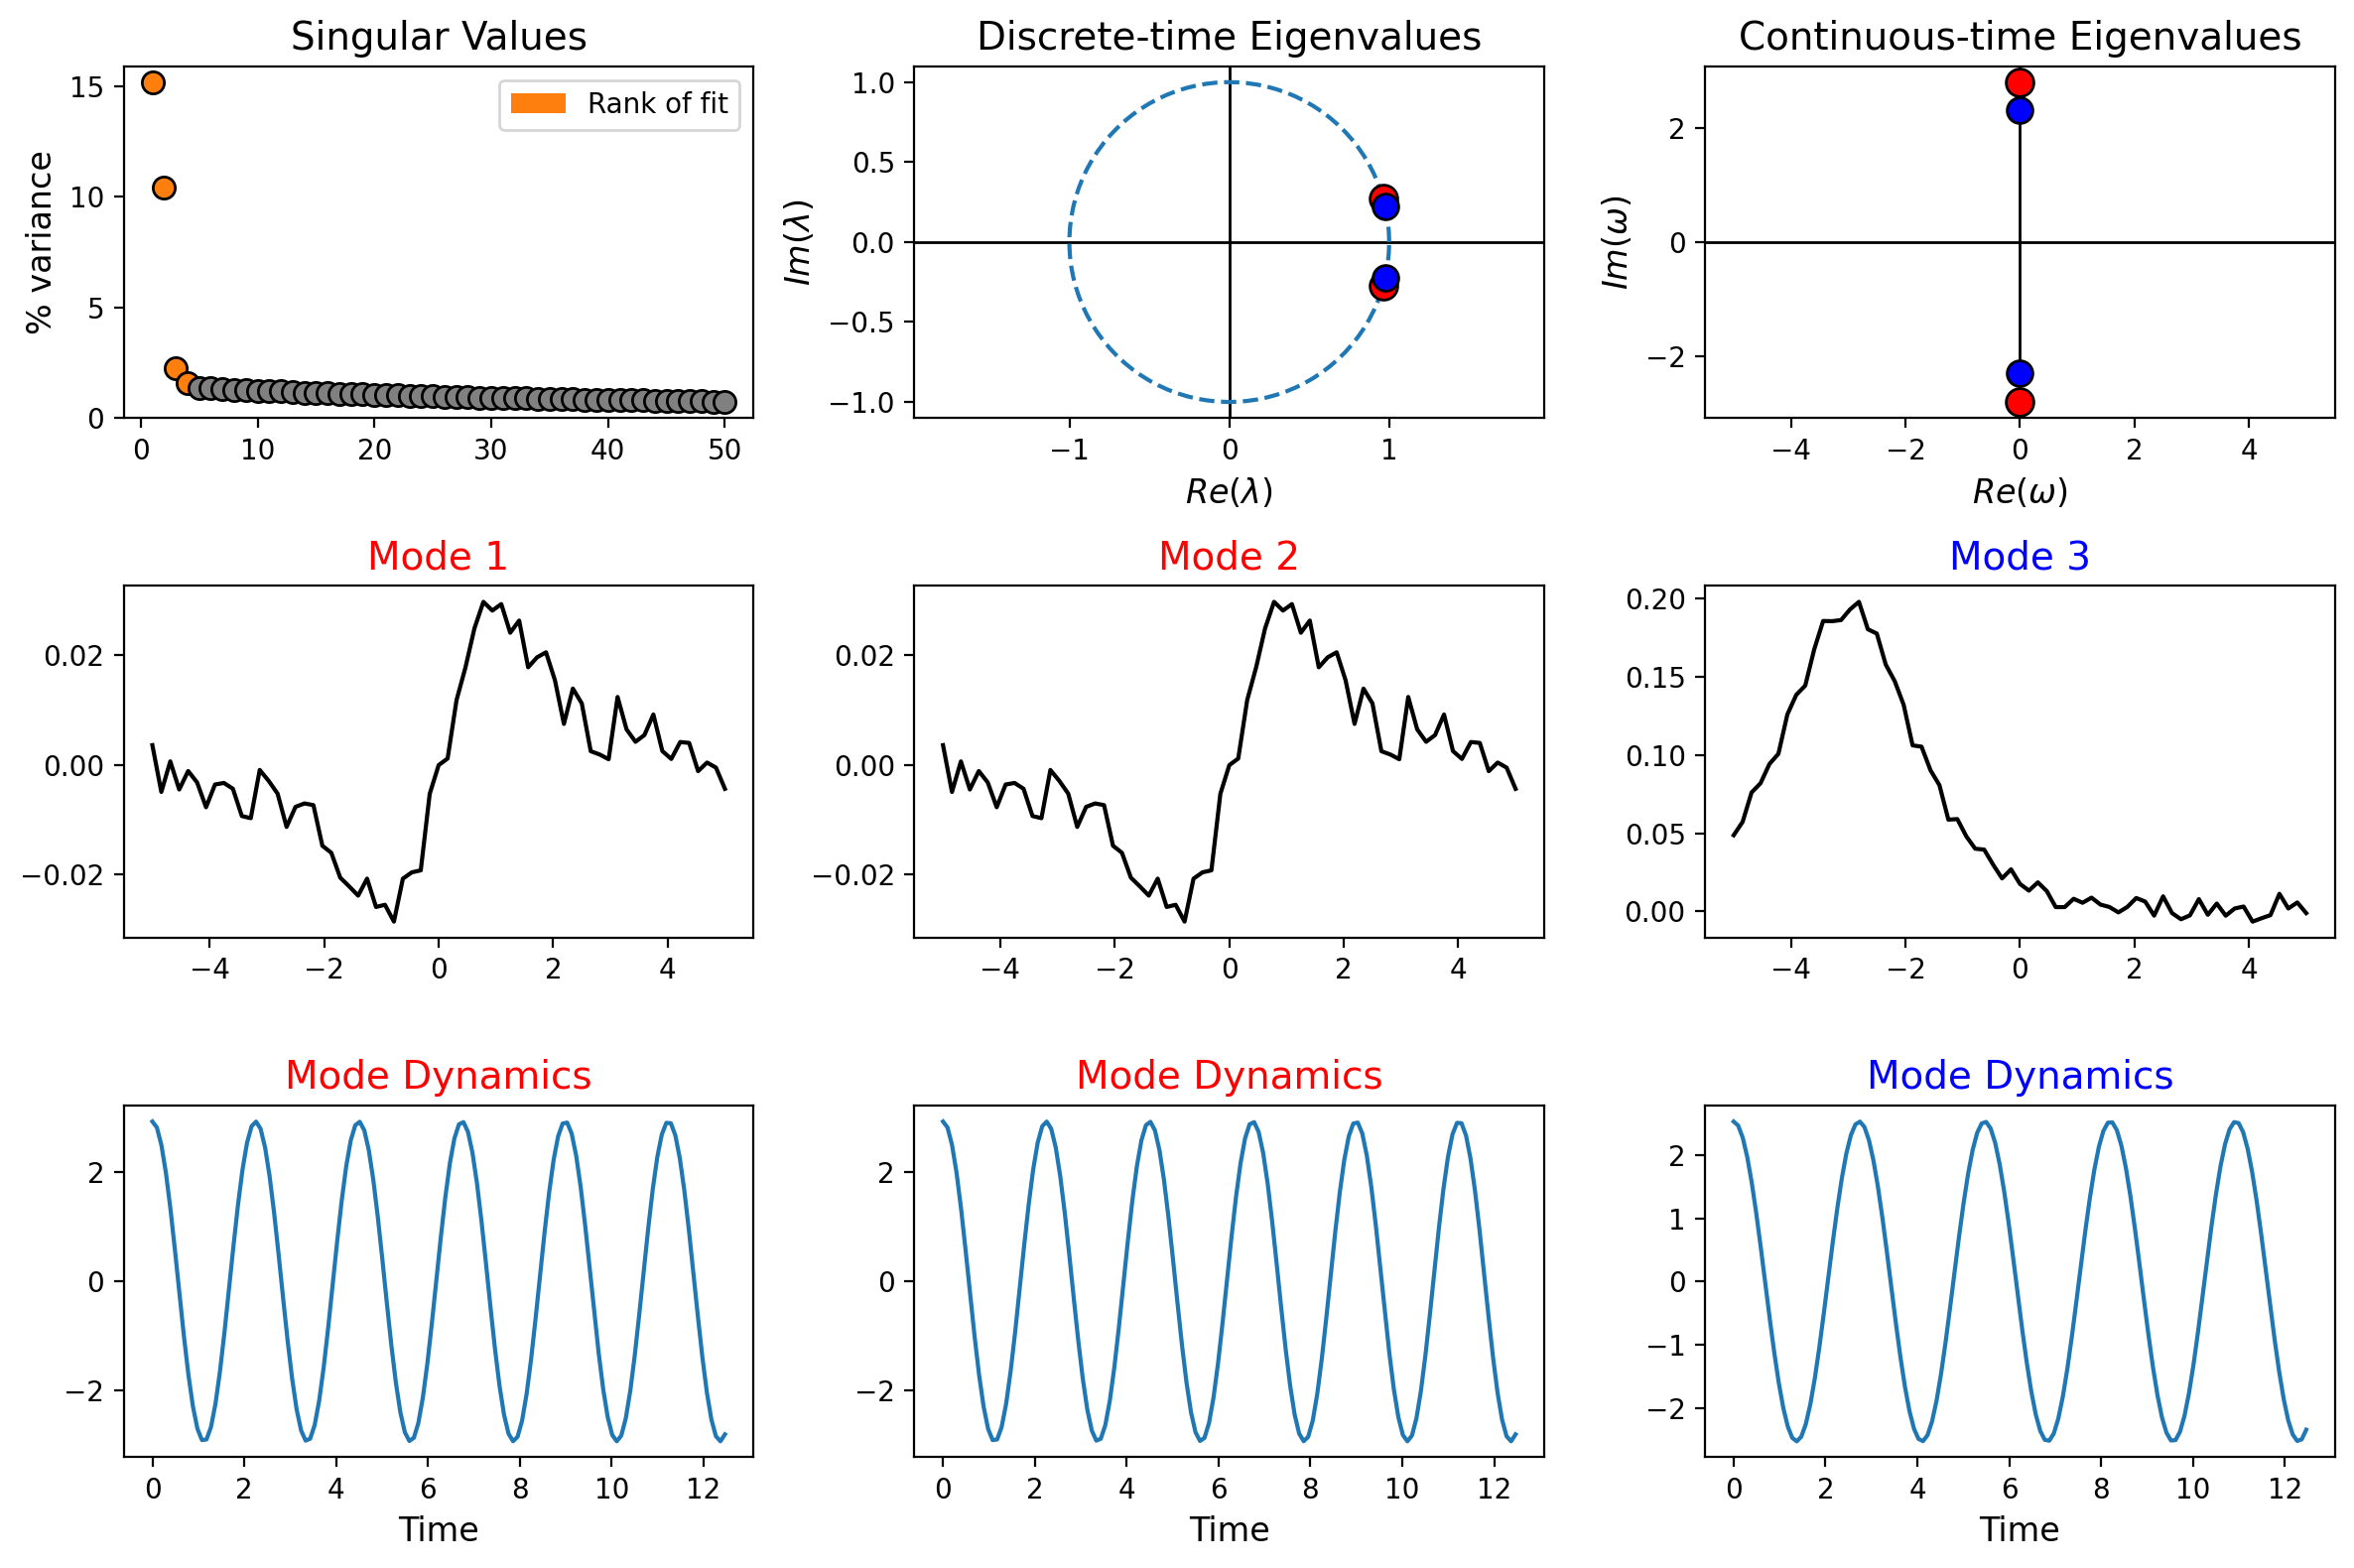

Frequencies (imaginary component): [ 0.+2.795j -0.-2.795j  0.+2.298j -0.-2.298j]


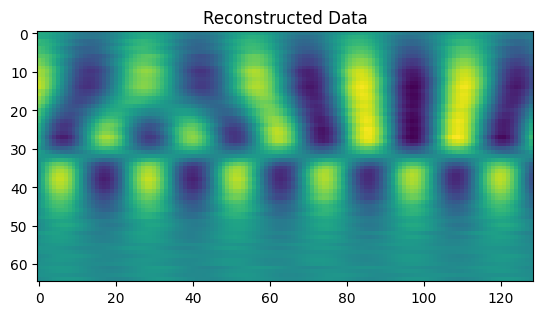

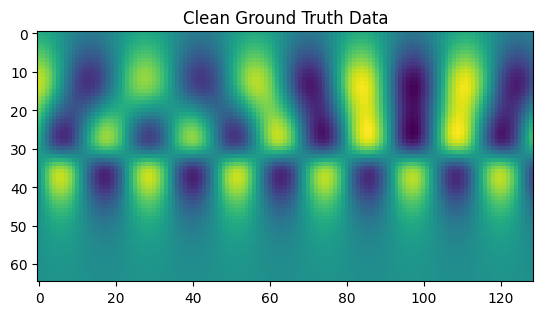

In [ ]:
# CONSTRAINTS

# Stable: constrain to the left-half plane (no positive real parts to eigenvalues).
# bopdmd = BOPDMD(eig_constraints={"stable"})

# Imaginary: constrain to imaginary axis (no real parts to eigenvalues).
# bopdmd = BOPDMD(eig_constraints={"imag"})

# Stable + Conjugate: constrain to the left-half plane and as complex conjugates.
# bopdmd = BOPDMD(eig_constraints={"stable", "conjugate_pairs"})

# Imaginary + Conjugate: constrain to imaginary axis and as complex conjugates.
# bopdmd = BOPDMD(eig_constraints={"imag", "conjugate_pairs"})

optdmd = BOPDMD(
    svd_rank=4, num_trials=0, eig_constraints={"imag", "conjugate_pairs"}
)
delay_optdmd = hankel_preprocessing(optdmd, d=d)
delay_optdmd.fit(Xn.T, t=delay_t)
plot_summary(delay_optdmd, x=x, d=d)

print(
    f"Frequencies (imaginary component): {np.round(delay_optdmd.eigs, decimals=3)}"
)
plt.title("Reconstructed Data")
plt.imshow(delay_optdmd.reconstructed_data.real)
plt.show()
plt.title("Clean Ground Truth Data")
plt.imshow(X.T)
plt.show()


## Why do we need time-delay?

**Because our data is real *and* because the underlying spatial modes are stationary, we cannot always obtain correct results if we apply DMD directly to our data set, even if we use the proper rank truncation.**

Time-delay helps mitigate this by giving us more observations to work with. As you will see below, our clean data reveals 2 dominant singular values, and if we try to apply DMD without time-delay, we obtain nonsensical results.

However, if we apply any number of time-delay embeddings, it will lift this number of singular values from 2 to 4, hence allowing us to more consistently extract the rank-4 structure that we expect. This is why we use `d=2` throughout this tutorial. Any number of delays greater than 1 suffice, granted we stil have enough temporal snapshots.

Note that this preprocessing step may or may not be necessary depending on your particular data set. Hence the most practical thing to do during any DMD application is to **examine the singular value spectrum of you data as you apply time-delay embeddings.**

### This is what happens without time-delay (using clean data and exact DMD):

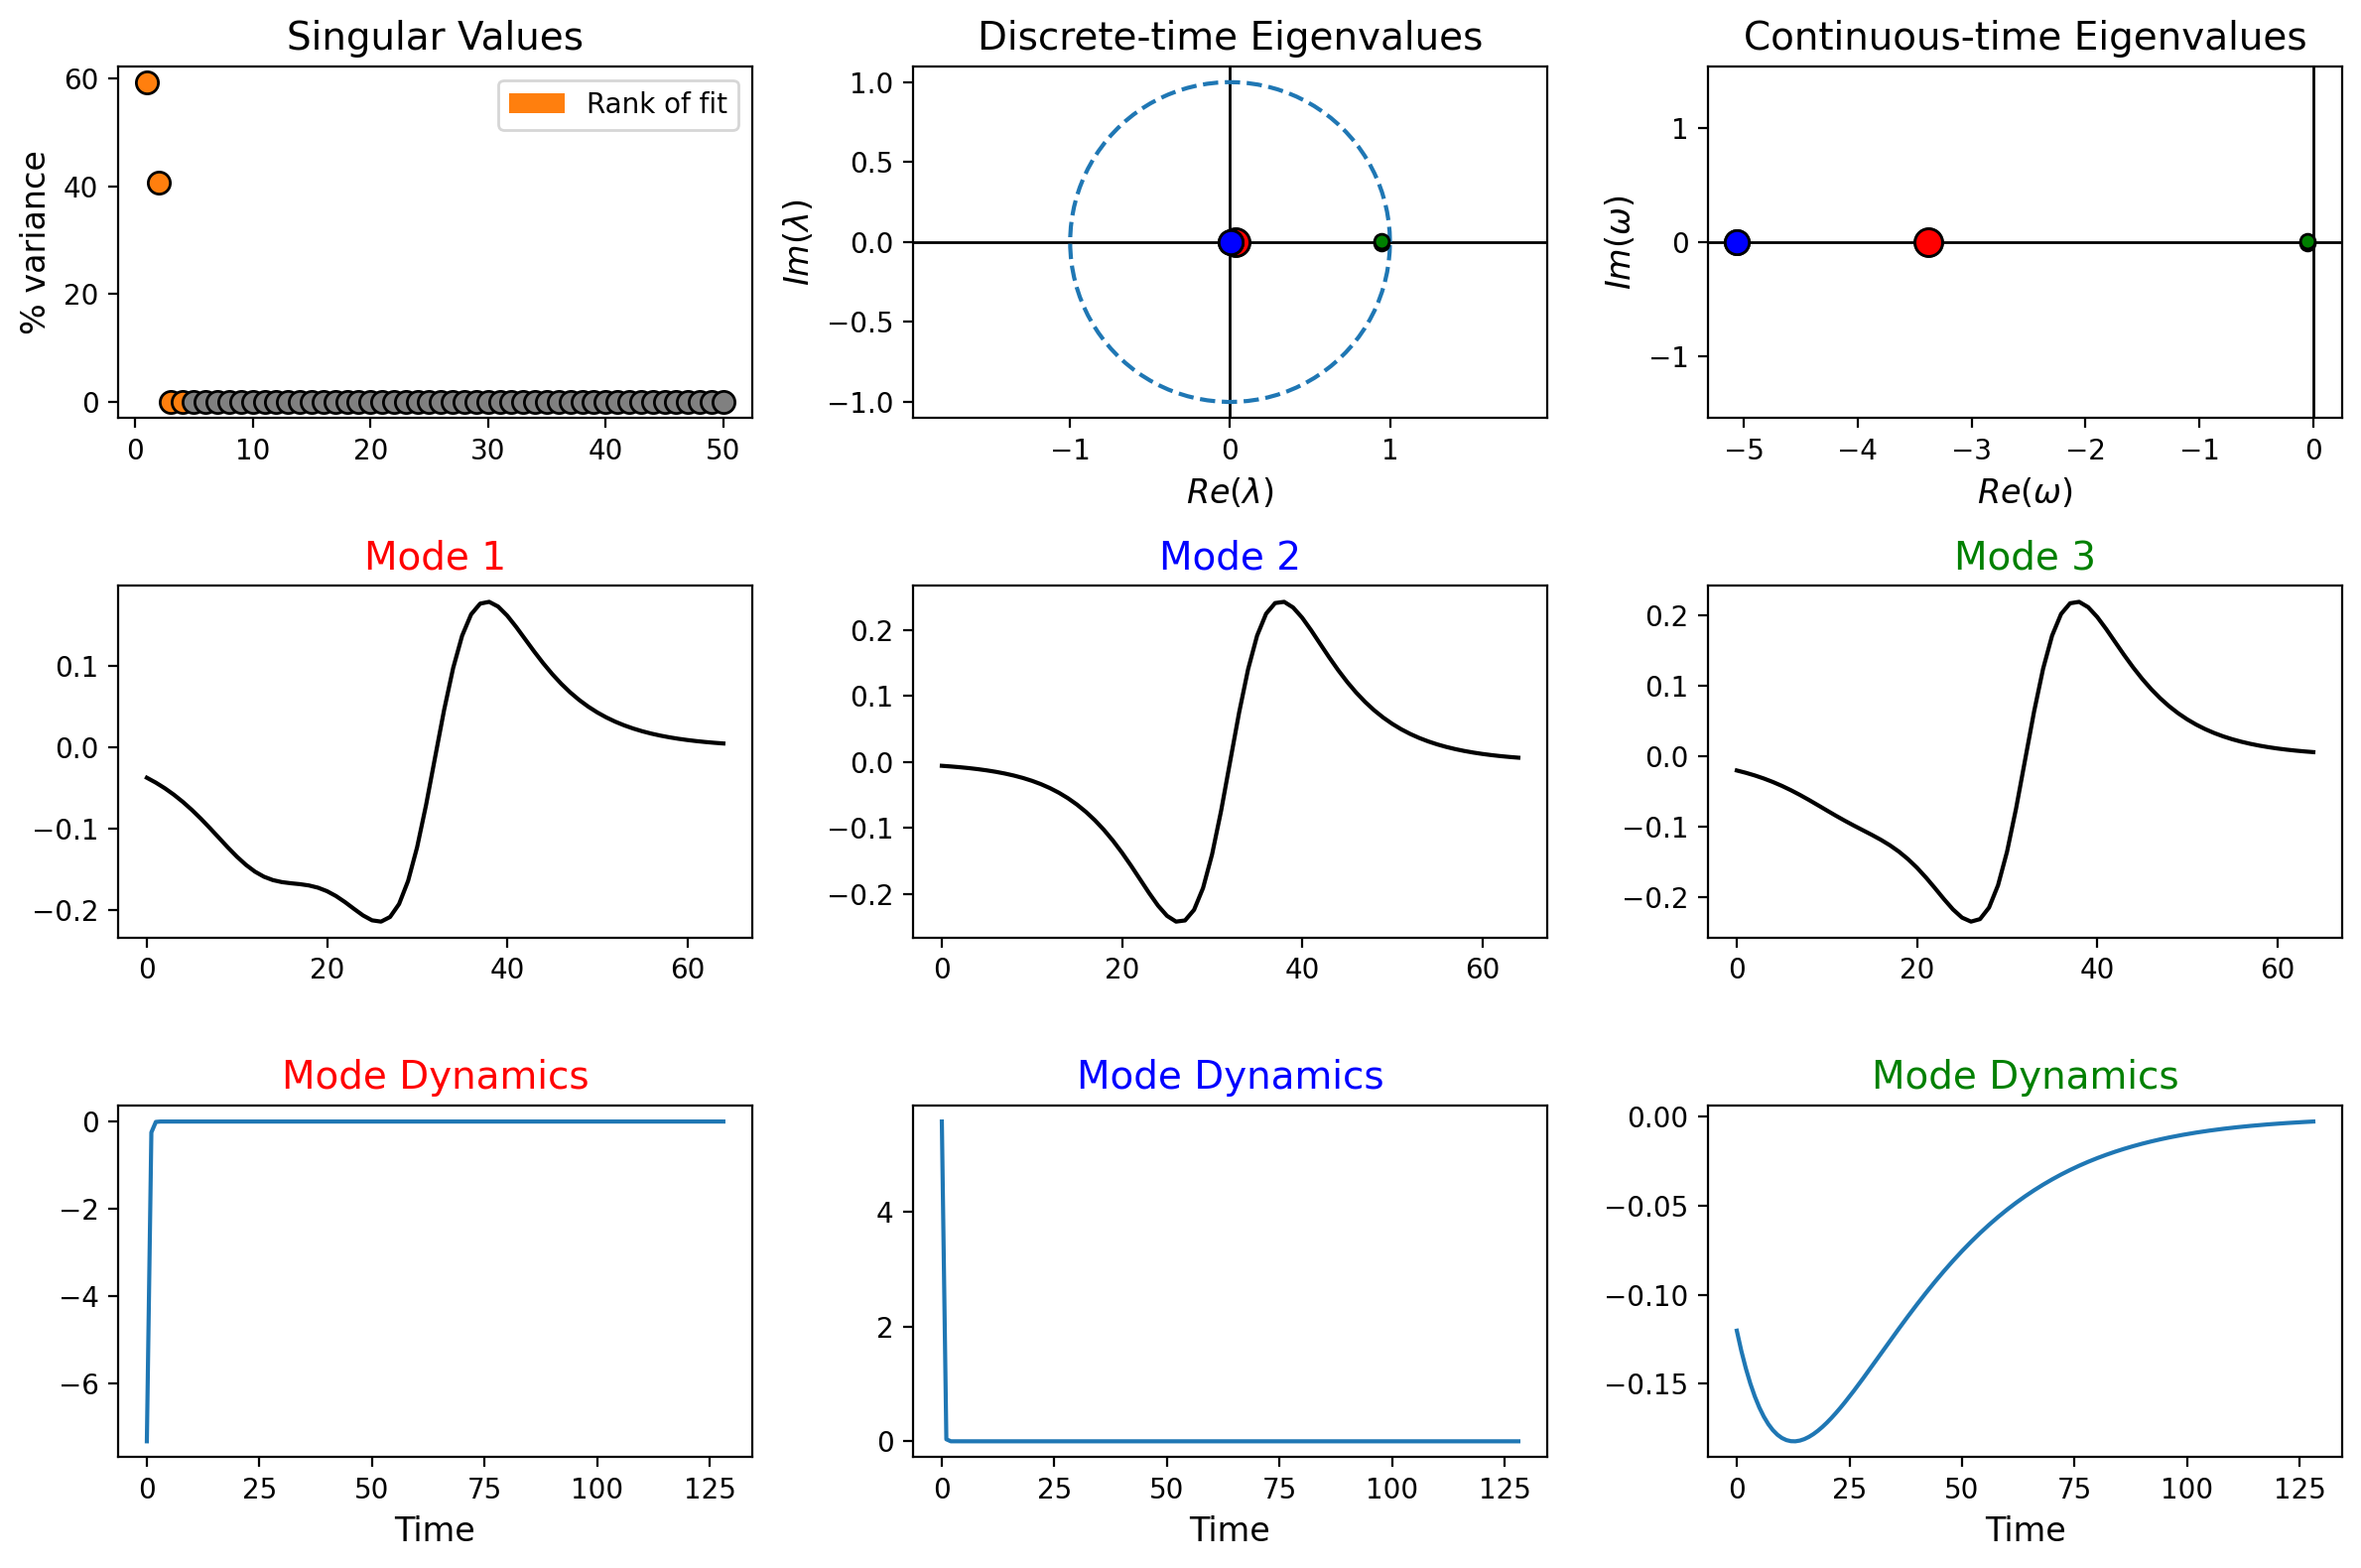

Frequencies (imaginary component): [ -0.525+0.09j  -0.525-0.09j -34.428+0.j   -51.553+0.j  ]


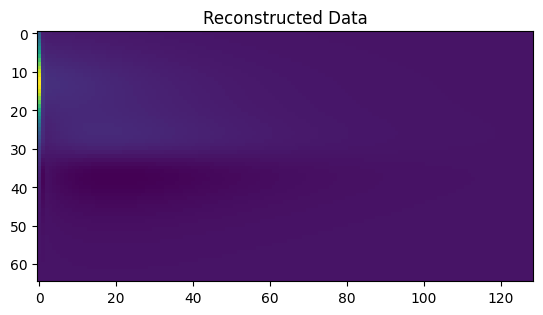

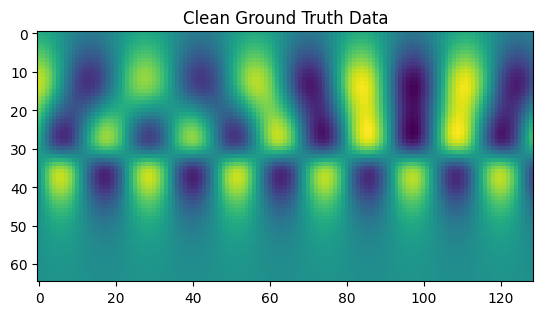

In [ ]:
dmd = DMD(svd_rank=4)
dmd.fit(X.T)
plot_summary(dmd)

print(
    f"Frequencies (imaginary component): {np.round(np.log(dmd.eigs) / dt, decimals=3)}"
)
plt.title("Reconstructed Data")
plt.imshow(dmd.reconstructed_data.real)
plt.show()
plt.title("Clean Ground Truth Data")
plt.imshow(X.T)
plt.show()

## Why do we use BOP-DMD?

**BOP-DMD is extremely robust to measurement noise, which is why it the preferred method when dealing with real-world data.** By contrast, the results of exact DMD are extremely sensitive to measurement noise.

Below, we demonstrate what might happen if you apply exact DMD to non-perfect data. Note the decay of the dynamics onset by the bias in the eigenvalues. Also notice how when we previously performed this fit but with BOP-DMD instead, we did not observe such decay, but rather we recovered the expected oscillatory dynamics.

### This is what happens when we use exact DMD instead of BOP-DMD:

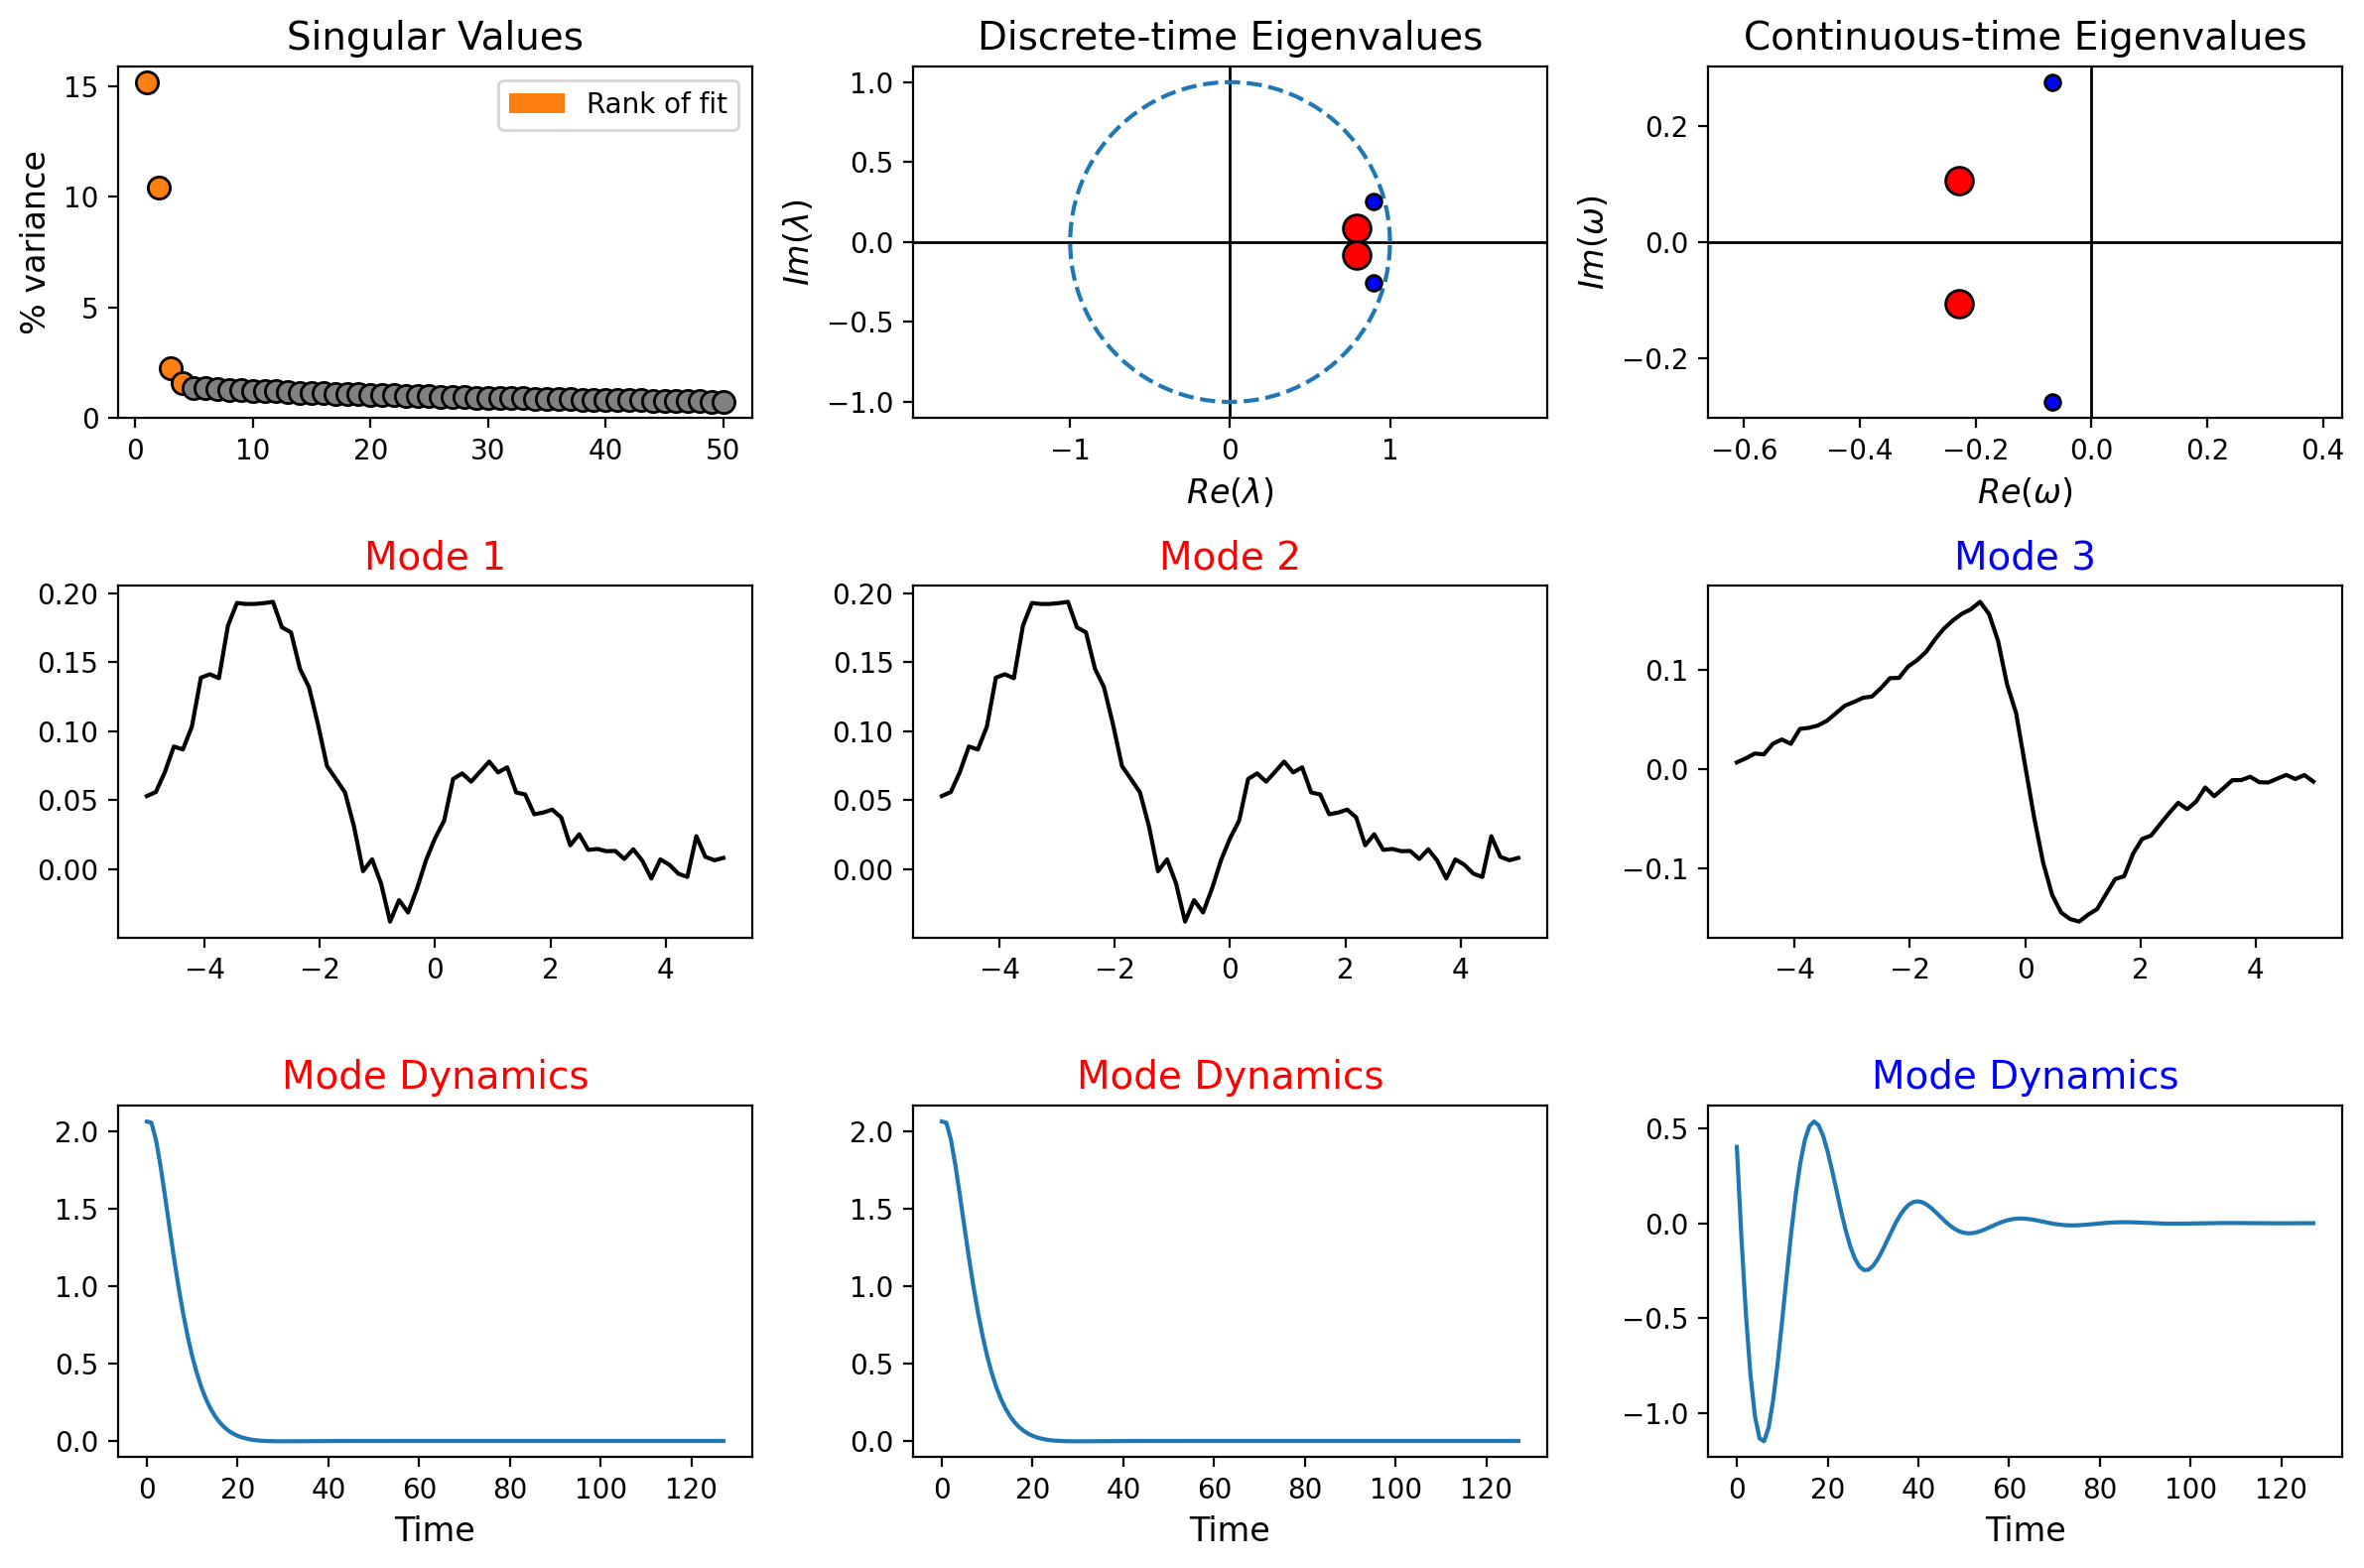

Frequencies (imaginary component): [-0.688+2.814j -0.688-2.814j -2.331+1.081j -2.331-1.081j]


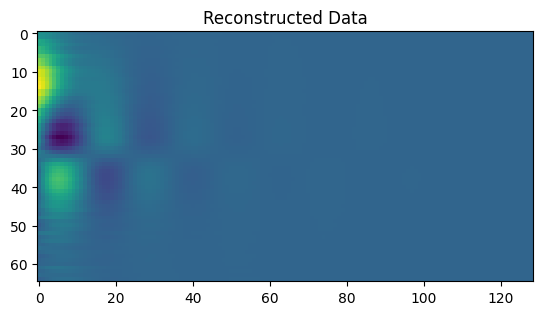

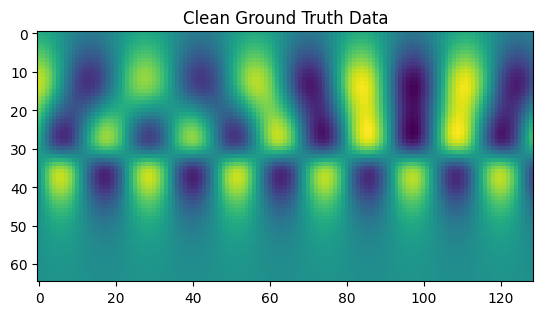

In [ ]:
dmd = DMD(svd_rank=4)
delay_dmd = hankel_preprocessing(dmd, d=d)
delay_dmd.fit(Xn.T)
plot_summary(delay_dmd, x=x, d=d)

print(
    f"Frequencies (imaginary component): {np.round(np.log(delay_dmd.eigs) / dt, decimals=3)}"
)
plt.title("Reconstructed Data")
plt.imshow(delay_dmd.reconstructed_data.real)
plt.show()
plt.title("Clean Ground Truth Data")
plt.imshow(X.T)
plt.show()